In [2]:

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.continuous import solve_ode
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.models import NeuralODE
from dynamics_discovery.preprocessing import split_into_chunks, standardize
from matplotlib_utils.axes_setters import set_labels


jax.config.update("jax_enable_x64", True)

In [2]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")
# dataset_loaded = TimeSeriesDataset.load("./data/lorenz_larger_tol.hdf5")
u_train, u_test = standardize(*dataset_loaded.u)


In [ ]:
neuralode = NeuralODE(3, 32, 3)

In [ ]:
dataset_loaded

In [4]:
train_length = 77
model = eqx.tree_deserialise_leaves(
    f"./results/lorenz_length={train_length}_key=0.eqx", neuralode
)
t_train_batch = split_into_chunks(dataset_loaded.t, train_length)
u_train_batch = split_into_chunks(u_train, train_length)

subsample_factor = u_train_batch.shape[0] // 100
print(t_train_batch.shape)
u_pred_train = eqx.filter_vmap(solve_ode, in_axes=(None, 0, 0))(
    model, t_train_batch[::subsample_factor], u_train_batch[::subsample_factor, 0]
)
u_pred_test = solve_ode(model, dataset_loaded.t, u_test[0], max_steps=None)


(1298, 77)


In [5]:
u_train, u_test, u_pred_train, u_pred_test = jax.tree.map(
    np.asarray, (u_train, u_test, u_pred_train, u_pred_test)
)

Text(0.5, 0.98, 'NeuralODE prediction (train length = 77)')

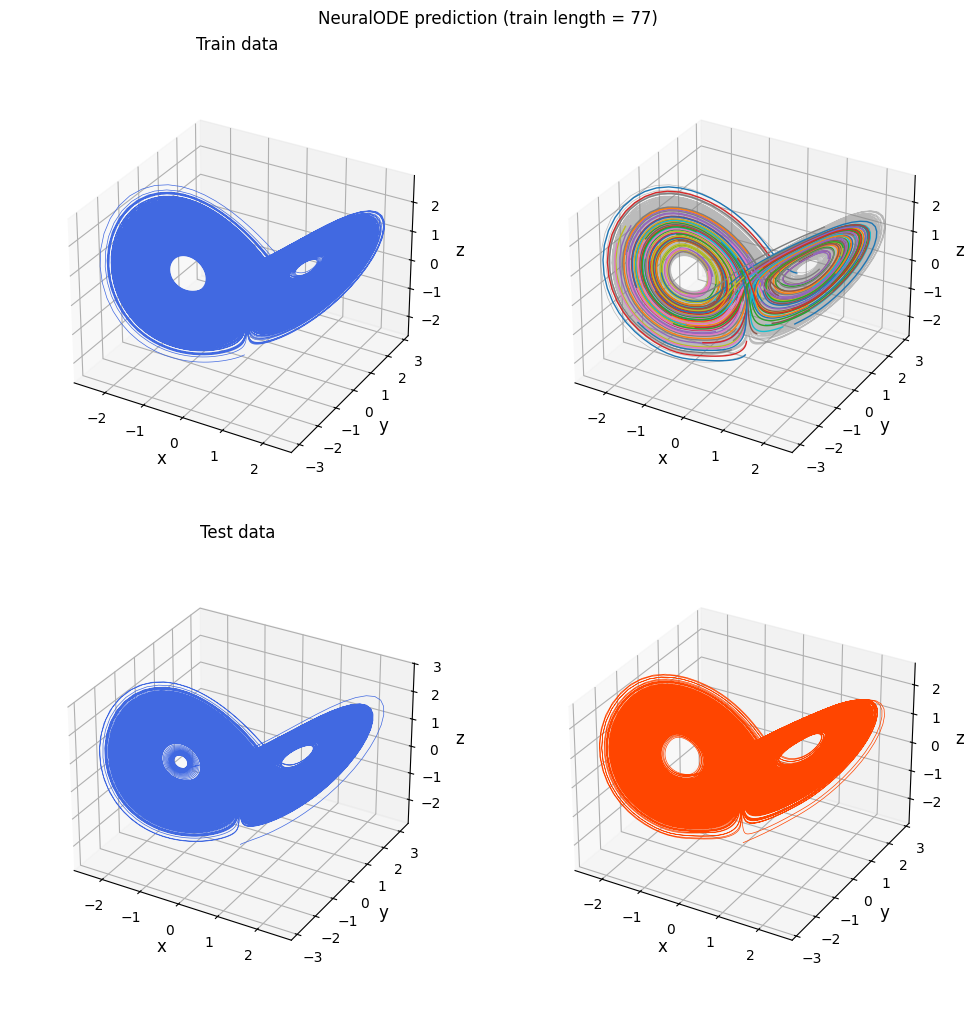

In [6]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0, 0].set_title("Train data")
axes[0, 0].plot(*u_train.T, color="royalblue", **plot_kwargs)
axes[0, 1].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
for u_i in np.asarray(u_pred_train):
    axes[0, 1].plot(*u_i.T, linewidth=1.0)
axes[1, 0].set_title("Test data")
axes[1, 0].plot(*u_test.T, color="royalblue", **plot_kwargs)
axes[1, 1].plot(*u_pred_test.T, color="orangered", **plot_kwargs)

for ax in axes.flat:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title
fig.suptitle(f"NeuralODE prediction (train length = {train_length})")
# fig.suptitle(r"32 bit precision, noise = 0")
# fig.suptitle(r"64 bit precision, noise ~ $\mathscr{N}(0, 0.05\cdot\sigma_{data})$")

Text(0.5, 0.98, 'Comparison of distributions for train_length=77')

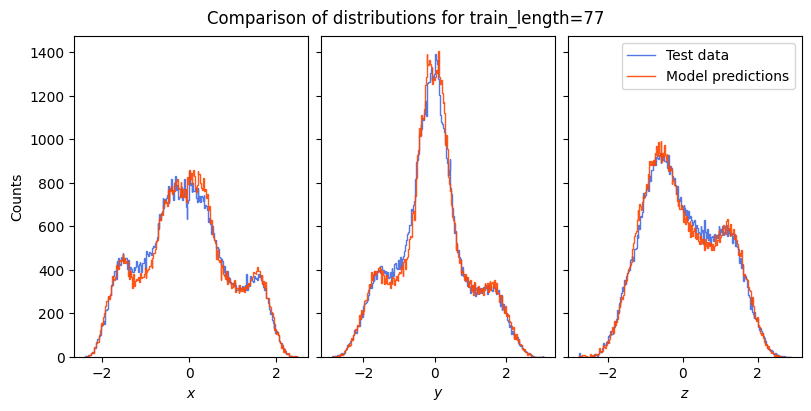

In [7]:
u_test_minmax = jnp.min(u_test, axis=0), jnp.max(u_test, axis=0)
u_pred_test_minmax = jnp.min(u_pred_test, axis=0), jnp.max(u_pred_test, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True, sharey=True)
xlabels = ("x", "y", "z")
for i, (ax, xlb) in enumerate(zip(axes, xlabels)):
    bins = np.linspace(
        min(u_test_minmax[0][i], u_pred_test_minmax[0][i]),
        max(u_test_minmax[1][i], u_pred_test_minmax[1][i]),
        250,
    )
    ax.stairs(
        *np.histogram(u_test[:, i], bins),
        color="royalblue",
        alpha=0.9,
        label="Test data",
    )
    ax.stairs(
        *np.histogram(u_pred_test[:, i], bins),
        color="orangered",
        alpha=0.9,
        label="Model predictions",
    )
    ax.set_xlabel(f"${xlb}$")
    # ax.set_yscale("log", base=10)
axes[0].set_ylabel("Counts")
axes[-1].legend(loc="upper right")
fig.suptitle(f"Comparison of distributions for {train_length=}")

In [8]:
def filter_map(fun, tree):
    params, static = eqx.partition(tree, eqx.is_array)
    params_mapped = jax.tree.map(fun, params)
    return eqx.combine(params_mapped, static)

In [9]:
neuralode, t, u_test = filter_map(
    jnp.float32, (NeuralODE(3, 32, 3), dataset_loaded.t, u_test)
)


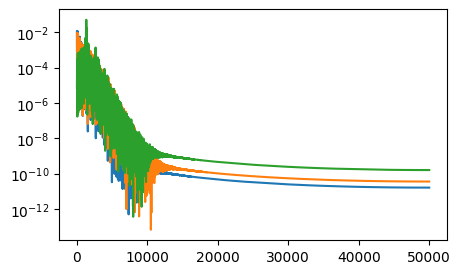

In [11]:
from jaxtyping import Array, Float
from tqdm import tqdm


def normalized_fft_intensity(x: Float[Array, "time dim"]):
    x_fft = jnp.fft.rfft(x, axis=0, norm="ortho")
    intensity = jnp.abs(x_fft) ** 2
    return intensity / jnp.sum(intensity, axis=0)


@jax.jit
def hellinger_dim(u_true, u_pred):
    intensity_true = normalized_fft_intensity(u_true)
    intensity_pred = normalized_fft_intensity(u_pred)
    integral_pq = jnp.trapezoid(jnp.sqrt(intensity_true * intensity_pred), axis=0)
    return jnp.mean(1 - integral_pq)


u_intensity = normalized_fft_intensity(u_test)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(u_intensity)
ax.set_yscale("log", base=10)

In [12]:
u_preds = []
batch_lengths = jnp.asarray([2, 10, 20, 50, 77, 100, 150, 200])
for seed in (0, 10, 20):
    u_pred_i = []
    for length in tqdm(batch_lengths):
        model = eqx.tree_deserialise_leaves(
            f"./results/x64/lorenz_length={length}_key={seed}.eqx", neuralode
        )
        u_pred = solve_ode(model, dataset_loaded.t, u_test[0], max_steps=None)
        u_pred_i.append(u_pred)
    u_preds.append(jnp.asarray(u_pred_i))

100%|██████████| 8/8 [01:05<00:00,  8.17s/it]


In [15]:
u_preds = jnp.asarray(u_preds)
u_preds.shape

(3, 8, 100000, 3)

In [45]:
models = [
    eqx.tree_deserialise_leaves(
        f"./results/lorenz_length={length}_key=0.eqx", neuralode
    )
    for length in batch_lengths
]
model_stacked = jax.tree.map(lambda *args: jnp.stack(args, axis=0), *models)

TypeError: stack requires ndarray or scalar arguments, got <class 'function'> at position 0.

In [16]:
hellinger = jax.vmap(jax.vmap(hellinger_dim, in_axes=(None, 0)), in_axes=(None, 0))(
    u_test, u_preds
)

In [51]:
hellinger.shape

(3, 8)

Text(0.5, 1.0, 'Results for small tolerance dataset; noise std = 0.05*data std')

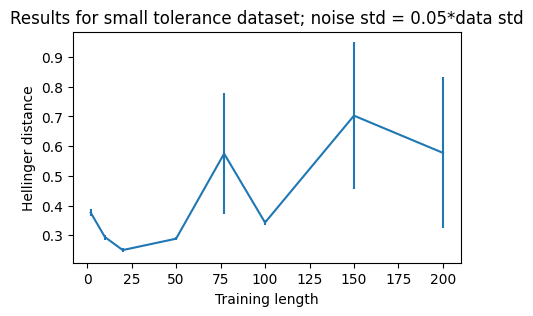

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.errorbar(
    batch_lengths,
    jnp.mean(hellinger, axis=0),
    yerr=jnp.std(hellinger, axis=0),
)
ax.set_xlabel("Training length")
ax.set_ylabel("Hellinger distance")
ax.set_title("Results for small tolerance dataset; noise std = 0.05*data std")

In [42]:
hellinger

[Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32)]